## Notebook Ejemplo Modificado

In [1]:
from keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [30]:
fashion_mnist = np.load('../AssignmentGoodies/train_images.npy')
print(fashion_mnist.shape)
x_data = fashion_mnist
y_data = pd.read_csv('../AssignmentGoodies/train_labels.csv').to_numpy()[:,0]
print(y_data.shape)

(60000, 28, 28)
(60000,)


In [31]:
y_data.shape

(60000,)

In [32]:
y_data[0]

9

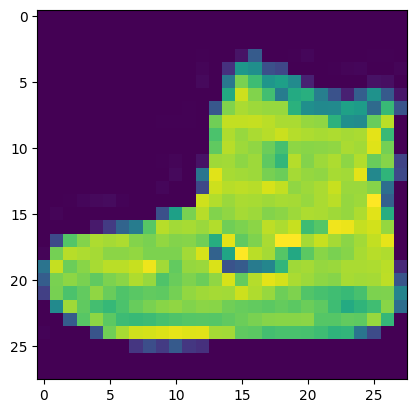

In [33]:
plt.imshow(x_data[0,...])

In [19]:
from sklearn import model_selection

In [35]:
# Split the train_valid sub-dataset into train and valid
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_data, y_data, test_size=1/3, random_state=10, shuffle=True)

In [36]:
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(40000, 28, 28) (20000, 28, 28) (40000,) (20000,)


In [37]:
y_sparse_train = np.zeros([40000,10])
y_sparse_valid = np.zeros([20000,10])

In [39]:
for idx in range(40000):
    y_sparse_train[idx,y_train[idx]] = 1

for idx in range(20000):
    y_sparse_valid[idx,y_valid[idx]] = 1

In [40]:
y_sparse_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [42]:
y_sparse_valid[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential

In [44]:
model =  Sequential()

In [45]:
model.add(Flatten(input_shape=(28,28)))

In [46]:
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(loss = "categorical_crossentropy", optimizer=Adam(learning_rate=0.0001),metrics=["accuracy"])

In [53]:
history = model.fit(x= x_train, y = y_sparse_train, validation_data=(x_valid, y_sparse_valid), batch_size = 128, epochs=20)

Epoch 1/20
313/313 [==============================] - 2s 6ms/step - loss: 0.6728 - accuracy: 0.7902 - val_loss: 0.7278 - val_accuracy: 0.7877
Epoch 2/20
313/313 [==============================] - 2s 5ms/step - loss: 0.5774 - accuracy: 0.8068 - val_loss: 0.6806 - val_accuracy: 0.7962
Epoch 3/20
313/313 [==============================] - 2s 5ms/step - loss: 0.5239 - accuracy: 0.8196 - val_loss: 0.6449 - val_accuracy: 0.8033
Epoch 4/20
313/313 [==============================] - 2s 6ms/step - loss: 0.4924 - accuracy: 0.8286 - val_loss: 0.6261 - val_accuracy: 0.8117
Epoch 5/20
313/313 [==============================] - 1s 5ms/step - loss: 0.4671 - accuracy: 0.8332 - val_loss: 0.6159 - val_accuracy: 0.8164
Epoch 6/20
313/313 [==============================] - 2s 5ms/step - loss: 0.4477 - accuracy: 0.8405 - val_loss: 0.5939 - val_accuracy: 0.8217
Epoch 7/20
313/313 [==============================] - 2s 6ms/step - loss: 0.4303 - accuracy: 0.8462 - val_loss: 0.5841 - val_accuracy: 0.8249
Epoch 

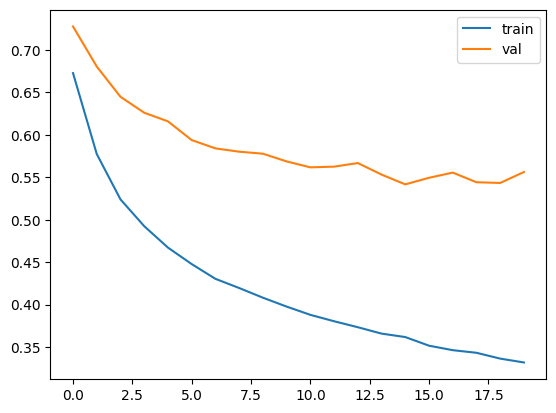

In [54]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()

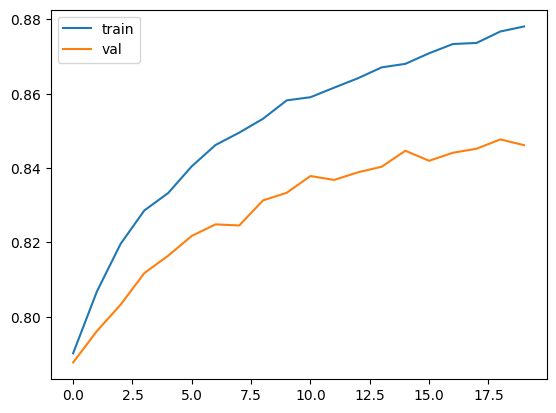

Max Accuracy: 0.8781
Max Val Accuracy: 0.8477


In [55]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.show()
maxAccuracy = max(history.history["accuracy"])
maxValAccuracy = max(history.history["val_accuracy"])
print(f"Max Accuracy: {maxAccuracy:.4f}")
print(f"Max Val Accuracy: {maxValAccuracy:.4f}")

## Con Conv2D

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

x_train_c, x_valid_c = x_train / 255.0, x_valid / 255.0

x_train_c = x_train_c[..., tf.newaxis]
x_valid_c = x_valid_c[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train_c, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_valid_c, y_valid)).batch(32)

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='test_accuracy')


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)


@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100))

Epoch 1, Loss: 0.4003010094165802, Accuracy: 85.8699951171875, Test Loss: 0.33552467823028564, Test Accuracy: 87.68499755859375
Epoch 2, Loss: 0.2564120888710022, Accuracy: 90.54499816894531, Test Loss: 0.289281964302063, Test Accuracy: 89.52999877929688
Epoch 3, Loss: 0.1948867291212082, Accuracy: 92.68000030517578, Test Loss: 0.302434504032135, Test Accuracy: 89.41500091552734
Epoch 4, Loss: 0.15130695700645447, Accuracy: 94.27000427246094, Test Loss: 0.29294663667678833, Test Accuracy: 90.375
Epoch 5, Loss: 0.11529947817325592, Accuracy: 95.69000244140625, Test Loss: 0.3269798159599304, Test Accuracy: 90.19499969482422
Epoch 6, Loss: 0.08658584207296371, Accuracy: 96.83250427246094, Test Loss: 0.34595683217048645, Test Accuracy: 90.06000518798828
Epoch 7, Loss: 0.06856217980384827, Accuracy: 97.58999633789062, Test Loss: 0.3647693991661072, Test Accuracy: 90.1449966430664
Epoch 8, Loss: 0.05207018554210663, Accuracy: 98.12750244140625, Test Loss: 0.4143773913383484, Test Accuracy: 9